In [1]:
pip install pynsee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 15.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pynsee.macrodata.get_series_list import get_series_list
from pynsee.macrodata.get_series import get_series
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from datetime import datetime

In [3]:
from pynsee import init_conn
init_conn(insee_key='OhPJjhlU6BcU1jgxYWzIWq1RcUka', insee_secret='pjqgGXAy7co3cMD4zZ8aytN5tq4a')

/opt/mamba/lib/python3.10/site-packages/pynsee/utils/_wait_api_query_limit.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  qCount.loc[r, "oneMin"] = (


In [4]:
#On récupère les prix à l'importation de l'énergie via l'API
energie_prix_import_insee = get_series('010535859')
##Idem pour l'Indice des Prix de Production total Industrie et l'Indice des Prix à la Consommation total
IPP_tot_insee = get_series('010535587')
IPC_tot_insee = get_series('001759970')

1/1 - Getting series: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


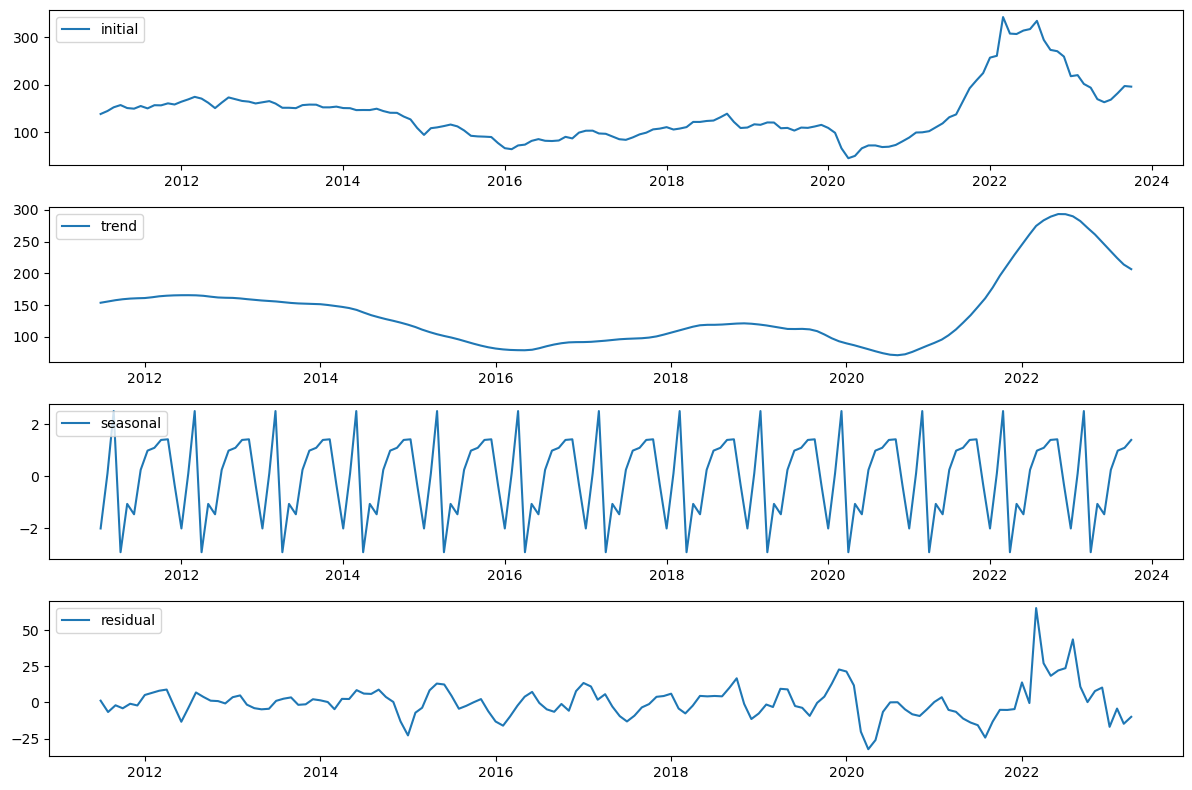

In [5]:
##Premières analyses des séries temporelles
energie_prix_import = energie_prix_import_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
energie_prix_import['TIME_PERIOD'] = pd.to_datetime(energie_prix_import['TIME_PERIOD'])
energie_prix_import.set_index('TIME_PERIOD',inplace=True)
result = seasonal_decompose(energie_prix_import,model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid
##Affichage graphique
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(energie_prix_import, label="initial")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label="seasonal")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
##On transforme également IPP et IPC en séries temporelles IPP
IPP_tot = IPP_tot_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
IPP_tot['TIME_PERIOD'] = pd.to_datetime(IPP_tot['TIME_PERIOD'])
IPP_tot.set_index('TIME_PERIOD',inplace=True)
IPC_tot = IPC_tot_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
IPC_tot['TIME_PERIOD'] = pd.to_datetime(IPC_tot['TIME_PERIOD'])
IPC_tot.set_index('TIME_PERIOD',inplace=True)
##Test de stationnarité des séries temporelles
energy_adf = adfuller(energie_prix_import)
IPP_tot_adf = adfuller(IPP_tot)
IPC_tot_adf = adfuller(IPC_tot)
print('p-value',energy_adf[1])
print('p-value',IPP_tot_adf[1])
print('p-value',IPC_tot_adf[1])
##On ne peut nulle part rejeter l'hypothèse nulle de non stationnarité, il faudra donc différencier les séries avant de faire les régressions

p-value 0.5940022688622959
p-value 0.9965016782275393
p-value 0.9937756551495907


In [7]:
##On régresse d'abord les coûts de l'énergie sur les prix de production globaux en stationnarisant les séries
data = pd.merge(energie_prix_import,IPP_tot, on='TIME_PERIOD', how="inner")
##On différencie les données pour travailler avec des séries stationnaires
data_diff = data.diff().dropna()
##On crée les valeurs lag des observations qui serviront de variables au modèle
lag_x = data_diff['OBS_VALUE_x'].shift(1)
lag_y = data_diff['OBS_VALUE_y'].shift(1)
data_diff['lag_x'] = lag_x
data_diff['lag_y'] = lag_y
data_diff = data_diff.dropna()
##Modelisation
X = sm.add_constant(data_diff[['lag_x','lag_y']])
y = data_diff['OBS_VALUE_y']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
##On a déjà un effet significatif des coûts de l'énergie, à préciser l'interprétation

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     16.83
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           2.56e-07
Time:                        11:29:37   Log-Likelihood:                -223.91
No. Observations:                 152   AIC:                             453.8
Df Residuals:                     149   BIC:                             462.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1922      0.089      2.155      0.0

In [112]:
##Si on modélise sur période plus courte
data_sub = data[data.index>"2020-01-31"]
##On différencie les données pour travailler avec des séries stationnaires
data_sub_diff = data_sub.diff().dropna()
##On crée les valeurs lag des observations qui serviront de variables au modèle
lag_x = data_sub_diff['OBS_VALUE_x'].shift(1)
lag_y = data_sub_diff['OBS_VALUE_y'].shift(1)
data_sub_diff['lag_x'] = lag_x
data_sub_diff['lag_y'] = lag_y
data_sub_diff = data_sub_diff.dropna()
##Modelisation
X = sm.add_constant(data_sub_diff[['lag_x','lag_y']])
y = data_sub_diff['OBS_VALUE_y']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     4.011
Date:                Thu, 16 Nov 2023   Prob (F-statistic):             0.0260
Time:                        13:35:52   Log-Likelihood:                -83.446
No. Observations:                  42   AIC:                             172.9
Df Residuals:                      39   BIC:                             178.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7110      0.309      2.303      0.0

In [8]:
##Test de la relation de co-intégration
from statsmodels.tsa.api import VAR, coint
data = pd.merge(energie_prix_import,IPP_tot, on='TIME_PERIOD', how="inner")
cointegration_test = coint(data['OBS_VALUE_x'],data['OBS_VALUE_y'])
print('p-value pour test de cointegration',cointegration_test[1])
##p-valeur = 0.41 Donc il existe bien une relation de co-intégration entre nos variables

p-value pour test de cointegration 0.386727326960111


In [21]:
##Raisonnement économétrique menant aux modèles ECM
data = pd.merge(energie_prix_import,IPP_tot, on='TIME_PERIOD', how="inner")
##Simple régression OLS
X = sm.add_constant(data[['OBS_VALUE_x']])
y = data['OBS_VALUE_y']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
##Comme la variable endogène n'est pas présente avec retard, on peut tester l'autocorrélation des résidus directement avec le test de Durbin-Watson
##le summary nous donne une valeur de 0.049, or pour que les résidus ne soient pas auto-corrélés à l'ordre 1, DW doit être proche de 2 (en pratique
##on accepte des modèle avec DW entre 1.5 et 2.5
##pour afficher directement la stat DW : 
from statsmodels.stats.stattools import durbin_watson
DW_stat = durbin_watson(results.resid)
print("La statistique de test de Durbin Watson a pour valeur : ",DW_stat)
##test d'homoscédasticité des résidus par le test de White
from statsmodels.stats.diagnostic import het_white
white_test = het_white(results.resid,X)
print("p-valeur du test de White : ",white_test[1])
##On rejette l'hypothèse d'homoscédasticité des résidus (p-valeur < 5%)
##Test de normalité des résidus (test de Jarque-Bera)
from scipy.stats import jarque_bera
jb_stat, p_value_JB = jarque_bera(results.resid)
print("p-valeur du test de Jarque-Bera : ",p_value_JB)
##On rejette l'hypothèse nulle de normalité des résidus

##Donc une régression simple n'est pas interprétable dans ces conditions
##La procédure de Cochrane-Orcutt peut être utilisée pour corriger de l'autocorrélation des erreurs
##Elle calcule l'autocorrélation empirique des résidus (rho) puis crée les variables Yt-rhoY(t-1) et idem pour Xt et 
##calcule l'autocrrélation des résidus de cette nouvelle régression etc jusqu'à ce qu'on obtienne une autocorrélation nulle
##Assure plus de confiance dans les test de Student et la significativité statistique des coefficients
from statsmodels.tsa.stattools import acf
acf_resid = acf(results.resid)
weights = -acf_resid[1:]
modele_cochrane_orcutt = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':12, 'weights':weights})
print(modele_cochrane_orcutt.summary())

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     261.0
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           9.97e-35
Time:                        07:50:26   Log-Likelihood:                -526.60
No. Observations:                 153   AIC:                             1057.
Df Residuals:                     151   BIC:                             1063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.2048      1.585     52.495      

In [51]:
##Test de rupture? Lorsque la plage de données est grande, il est possible que le phénomène économique d'intérêt ait subi des altérations et des ruptures.
##Le test de Chow peut être utilisé pour détecter des changements strucutrels dans les coefficients d'un modèle de régression
from statsmodels.stats.diagnostic import linear_harvey_collier
data["groupe"] = data.index>"2018-01-01"
data['interaction'] = data["groupe"]*data['OBS_VALUE_x']
#Modele avec interaction
modele_interaction = sm.OLS(data['OBS_VALUE_y'], sm.add_constant(data[['OBS_VALUE_x','interaction']])).fit()
modele_ss_interaction = sm.OLS(data['OBS_VALUE_y'], sm.add_constant(data[['OBS_VALUE_x']])).fit()
chow_test = modele_ss_interaction.compare_f_test(modele_interaction)
print(chow_test)
##Problème d'hétéroscédasticité et d'autocorrélation dans les résidus, ne donne pas de résultats utilisables
##Valeur de stat de 68.4, donc on s'attend tout de même à un rejet de l'hypothèse nulle

(68.36054829348649, nan, -1.0)


In [92]:
##Modele à Correction d'Erreur
##On a déjà validé l'hypothèse d'une relation de co-intégration, il faudrait vérifier que les séries considérées sont intégrées d'ordre 1
##Test de stationnarité des séries temporelles
data = pd.merge(energie_prix_import,IPP_tot, on='TIME_PERIOD', how="inner")
data_diff = data.diff().dropna()
energy_adf = adfuller(data_diff['OBS_VALUE_x'])
IPP_adf = adfuller(data_diff['OBS_VALUE_y'])
print('p-value',energy_adf[1])
print('p-value',IPP_adf[1])
##Parfait, les test de stationnarité rejettent l'hypothèse nulle de non stationanrité des séries utilisées
##Donc les hypothèses nécessaires pour mettre en place un modèle ECM sont bien vérifiées
##Equation de long terme
long_terme = sm.OLS(data['OBS_VALUE_y'], sm.add_constant(data[['OBS_VALUE_x']])).fit()
print(long_terme.summary())
residus = long_terme.resid
##Equation de court terme
residus_lag = pd.Series(residus.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on='TIME_PERIOD', how="inner")
court_terme = sm.OLS(data_courte['OBS_VALUE_y'], sm.add_constant(data_courte[['OBS_VALUE_x','residus']])).fit()
print(court_terme.summary())
##Le coefficient devant residus peut s'interpréter comme une vitesse de convergence, il est bien négatif comme attendu
##Ici il vaut 1,4%, ce qui signifie qu'à chaque mois, la variable y comble 1,4% de l'écart à sa valeur de long terme (attention ici on a peu de variables explicatives)
##En l'absence de chocs consécutifs, il faudrait donc 100/1.4 = 71 mois soit environ 6 ans pour un retour à l'équilibre

##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
##Problème, on a un résidu non stationnaire bien que les séries régressées soient stationnaires...
##Attention, dans ce contexte de modèle ECM, aucune loi n'est connue pour les estimateurs, il est donc impossible d'interpréter les tests statistiques sur les coefficients

p-value 0.00043473487842457715
p-value 0.04591807062137716
                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     261.0
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           9.97e-35
Time:                        09:28:27   Log-Likelihood:                -526.60
No. Observations:                 153   AIC:                             1057.
Df Residuals:                     151   BIC:                             1063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [9]:
##Pour limiter le biais introduit à la première étape, Stock et Watson propose des dynamic OLS, où on introduit symétriquement des variations avance et retard dans la première étape
data = pd.merge(energie_prix_import,IPP_tot, on='TIME_PERIOD', how="inner")
nombre_retard = 2
for i in range(1,nombre_retard+1):
    data[f'Delta_X_lag_{i}'] = data['OBS_VALUE_x']-data['OBS_VALUE_x'].shift(i)
    data[f'Delta_X_lead_{i}'] = data['OBS_VALUE_x']-data['OBS_VALUE_x'].shift(-i)
data = data.dropna()

##Equation de long terme
long_terme = sm.OLS(data['OBS_VALUE_y'], sm.add_constant(data[['OBS_VALUE_x','Delta_X_lag_1','Delta_X_lag_2','Delta_X_lead_1','Delta_X_lead_2']])).fit()
print(long_terme.summary())
residus = long_terme.resid
##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
##Toujours pas stationnaire

##Equation de court terme
##Attention il faut un peu transformer le résidu avant de l'introduire dans l'équation de court terme
residus_trans = data['OBS_VALUE_y']-long_terme.params['OBS_VALUE_x']*data['OBS_VALUE_x']-long_terme.params['const']
residus_lag = pd.Series(residus_trans.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on='TIME_PERIOD', how="inner")
court_terme = sm.OLS(data_courte['OBS_VALUE_y'], sm.add_constant(data_courte[['OBS_VALUE_x','residus']])).fit()
print(court_terme.summary())
##On passe de 1,4% à 1,8% pour la force de rappel, pas de grande différence

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     62.65
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           2.00e-34
Time:                        11:30:18   Log-Likelihood:                -503.16
No. Observations:                 150   AIC:                             1018.
Df Residuals:                     144   BIC:                             1036.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             82.2206      1.522     54.

p-valeur du test de co-intégration :  0.386727326960111


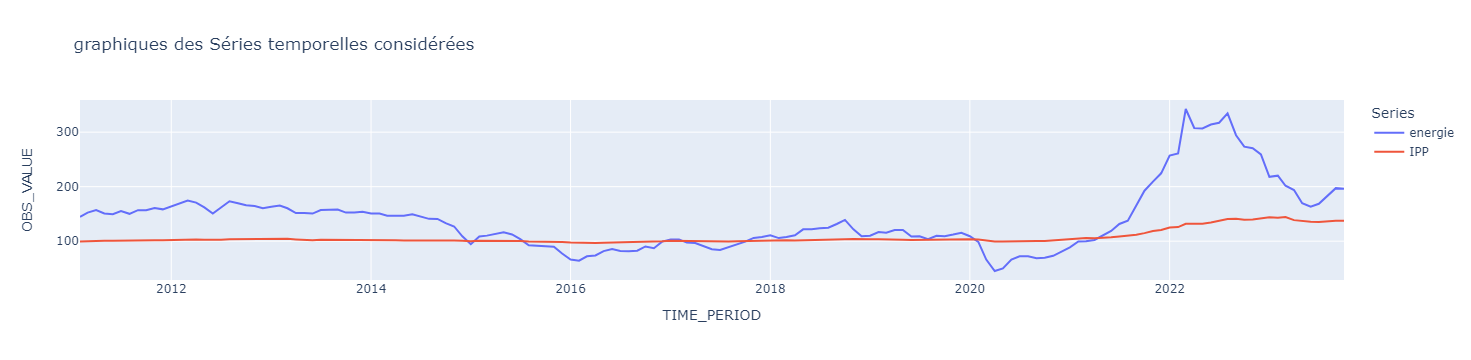

In [19]:
## Poursuite du code et reprise des analyses
data = pd.merge(energie_prix_import,IPP_tot, on='TIME_PERIOD', how="inner")
##Test de co-intégration
from statsmodels.tsa.stattools import coint
test_coint = coint(data['OBS_VALUE_x'],data['OBS_VALUE_y'])
print("p-valeur du test de co-intégration : ", test_coint[1])
##On ne peut donc pas rejeter l'hypothèse nulle de non co-intégration, de ce fait on ne pourra pas trouver une relation de long terme pour le modèle ECM
##On pouvait déjà avoir une idée de l'existence ou non d'une relation de co-intégration avec des graphiques
import plotly.express as px
energie_prix_import["Series"]="energie"
IPP_tot["Series"]="IPP"
data_plot = pd.concat([energie_prix_import,IPP_tot])
data_plot = data_plot[data_plot.index>"2011-01-31"]
fig = px.line(data_plot, x=data_plot.index, y='OBS_VALUE', color='Series', title = "graphiques des Séries temporelles considérées", hover_data={'OBS_VALUE':':.2f'})
fig.show()

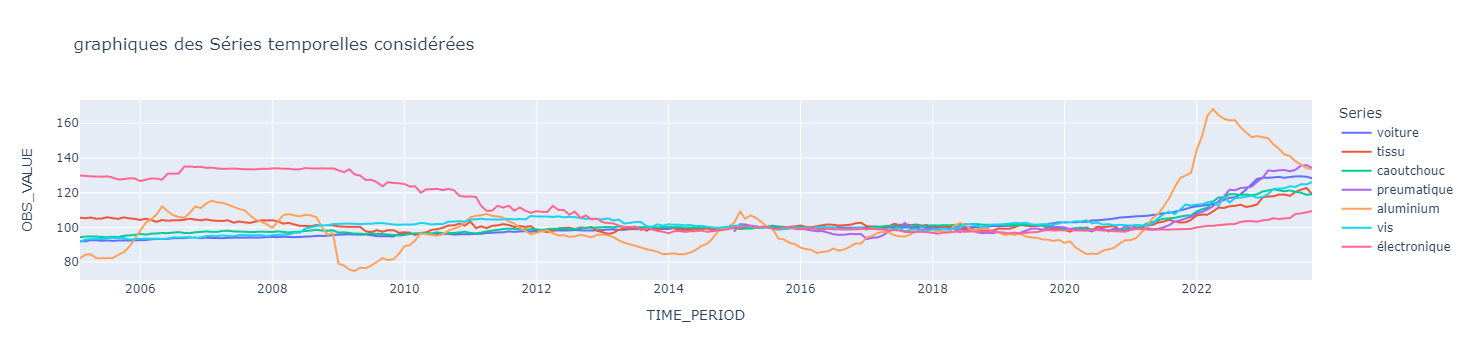

In [90]:
##On va donc utiliser d'autres données pour expliciter la méthode des ECM
init_conn(insee_key='OhPJjhlU6BcU1jgxYWzIWq1RcUka', insee_secret='pjqgGXAy7co3cMD4zZ8aytN5tq4a')
prix_voit_insee = get_series('010534366')
prix_voit = prix_voit_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
prix_voit['TIME_PERIOD'] = pd.to_datetime(prix_voit['TIME_PERIOD'])
prix_voit.set_index('TIME_PERIOD',inplace=True)
prix_voit["Series"]="voiture"
prix_tissu_insee = get_series('010534078')
prix_tissu = prix_tissu_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
prix_tissu['TIME_PERIOD'] = pd.to_datetime(prix_tissu['TIME_PERIOD'])
prix_tissu.set_index('TIME_PERIOD',inplace=True)
prix_tissu["Series"]="tissu"
prix_caoutc_insee = get_series('010534200')
prix_caoutc = prix_caoutc_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
prix_caoutc['TIME_PERIOD'] = pd.to_datetime(prix_caoutc['TIME_PERIOD'])
prix_caoutc.set_index('TIME_PERIOD',inplace=True)
prix_caoutc["Series"]="caoutchouc"
prix_pneum_insee = get_series('010534202')
prix_pneum = prix_pneum_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
prix_pneum['TIME_PERIOD'] = pd.to_datetime(prix_pneum['TIME_PERIOD'])
prix_pneum.set_index('TIME_PERIOD',inplace=True)
prix_pneum["Series"]="preumatique"
prix_alu_insee = get_series('010534272')
prix_alu = prix_alu_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
prix_alu['TIME_PERIOD'] = pd.to_datetime(prix_alu['TIME_PERIOD'])
prix_alu.set_index('TIME_PERIOD',inplace=True)
prix_alu["Series"]="aluminium"
prix_vis_insee = get_series('010534314')
prix_vis = prix_vis_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
prix_vis['TIME_PERIOD'] = pd.to_datetime(prix_vis['TIME_PERIOD'])
prix_vis.set_index('TIME_PERIOD',inplace=True)
prix_vis["Series"]="vis"
prix_electro_insee = get_series('010534318')
prix_electro = prix_electro_insee.loc[:,['TIME_PERIOD','OBS_VALUE']]
prix_electro['TIME_PERIOD'] = pd.to_datetime(prix_electro['TIME_PERIOD'])
prix_electro.set_index('TIME_PERIOD',inplace=True)
prix_electro["Series"]="électronique"
data_plot = pd.concat([prix_voit,prix_tissu,prix_caoutc,prix_pneum,prix_alu,prix_vis,prix_electro])
data_plot = data_plot[data_plot.index>"2005-01-31"]
fig = px.line(data_plot, x=data_plot.index, y='OBS_VALUE', color='Series', title = "graphiques des Séries temporelles considérées", hover_data={'OBS_VALUE':':.2f'})
fig.show()

p-value  voit   0.005479583355177443
p-value  tissu   0.8247711051732571
p-value  caoutc   0.01539240273249019
p-value  pneum   3.5554034068261476e-05
p-value  alu   0.06285176739552743
p-value  vis   0.046265225564928195
p-value  elect   0.1138091991385361
                            OLS Regression Results                            
Dep. Variable:                   voit   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.342
Date:                Thu, 30 Nov 2023   Prob (F-statistic):             0.0372
Time:                        13:48:47   Log-Likelihood:                -85.268
No. Observations:                 105   AIC:                             184.5
Df Residuals:                      98   BIC:                             203.1
Df Model:                           6                                         
Covariance Type:            non

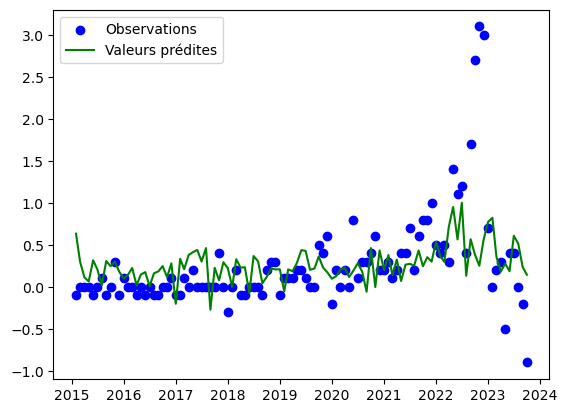

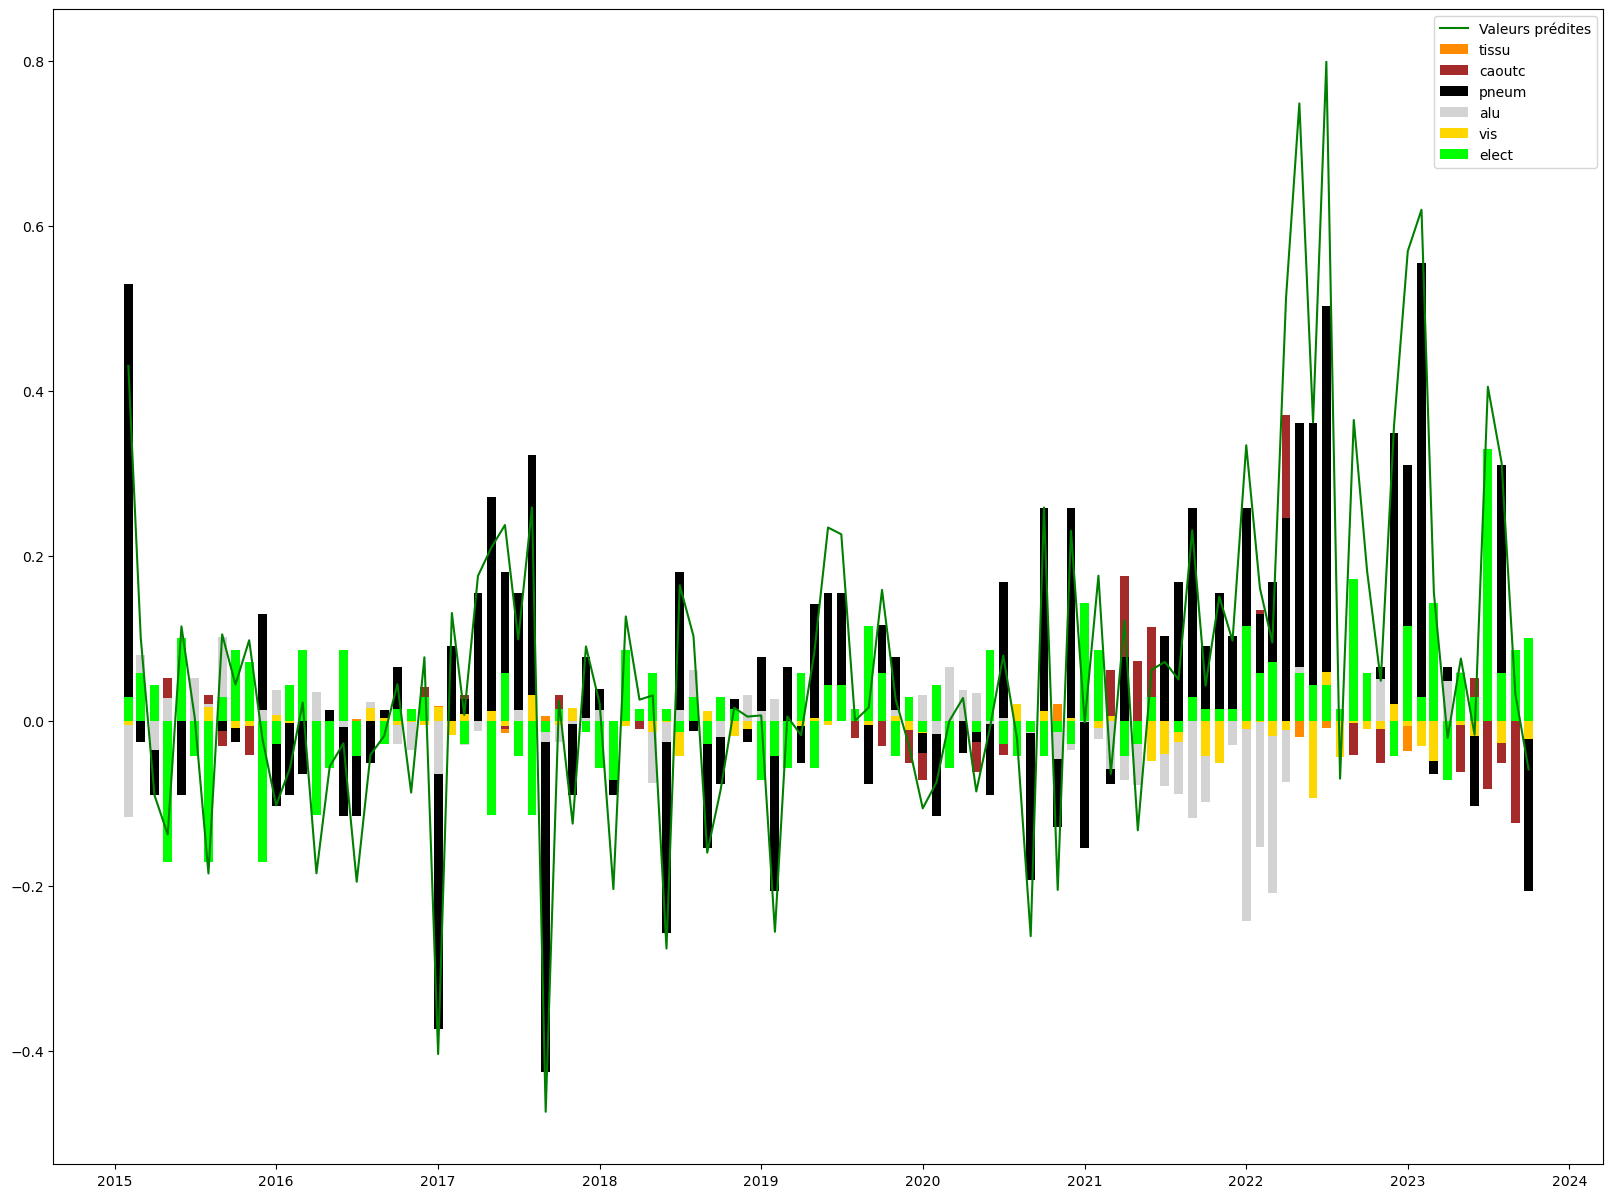

In [133]:
###Simple regression sur les variables différenciées
##On vérifie d'abord la stationnarité de ces nouvelles variables
#Construction de la base
prix_voit = prix_voit[prix_voit.index>"2005-01-31"]
prix_voit = prix_voit.rename(columns={'OBS_VALUE': 'voit'})
prix_tissu = prix_tissu[prix_tissu.index>"2005-01-31"]
prix_tissu = prix_tissu.rename(columns={'OBS_VALUE': 'tissu'})
prix_caoutc = prix_caoutc[prix_caoutc.index>"2005-01-31"]
prix_caoutc = prix_caoutc.rename(columns={'OBS_VALUE': 'caoutc'})
prix_pneum = prix_pneum[prix_pneum.index>"2005-01-31"]
prix_pneum = prix_pneum.rename(columns={'OBS_VALUE': 'pneum'})
prix_alu = prix_alu[prix_alu.index>"2005-01-31"]
prix_alu = prix_alu.rename(columns={'OBS_VALUE': 'alu'})
prix_vis = prix_vis[prix_vis.index>"2005-01-31"]
prix_vis = prix_vis.rename(columns={'OBS_VALUE': 'vis'})
prix_electro = prix_electro[prix_electro.index>"2005-01-31"]
prix_electro = prix_electro.rename(columns={'OBS_VALUE': 'elect'})

data = pd.merge(prix_voit['voit'],prix_tissu['tissu'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_caoutc['caoutc'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_pneum['pneum'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_alu['alu'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_vis['vis'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_electro['elect'], on='TIME_PERIOD', how="inner")

##On différencie les données pour travailler avec des séries stationnaires
data_diff = data.diff().dropna()
##On vérifie la stationnarité des séries utilisées
for i in ['voit','tissu','caoutc','pneum','alu','vis','elect'] :
    test_adf = adfuller(data_diff[i])
    print('p-value ', i,' ', test_adf[1])

##Seul le test de stationnarité sur le tissu est dangereux pour notre analyse, les autres variables donnent des résultats acceptables
X = sm.add_constant(data_diff[['tissu','caoutc','pneum','alu','vis','elect']])
y = data_diff['voit']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
##Pas terrible...

##Outil de visualisation
contributions = X * results.params
y_pred = results.predict(X)
import matplotlib.pyplot as plt
plt.scatter(X.index,y, label="Observations", color="blue")
plt.plot(X.index, y_pred, label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()

plt.figure(figsize=(20,15))
plt.bar(X.index,contributions['tissu'], label = "tissu", color="darkorange",width=20)
plt.bar(X.index,contributions['caoutc'], label = "caoutc", color="brown",width=20)
plt.bar(X.index,contributions['pneum'], label = "pneum", color="black",width=20)
plt.bar(X.index,contributions['alu'], label = "alu", color="lightgray",width=20)
plt.bar(X.index,contributions['vis'], label = "vis", color="gold",width=20)
plt.bar(X.index,contributions['elect'], label = "elect", color="lime",width=20)
plt.plot(X.index, y_pred-contributions['const'], label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()